In [1]:
from sklearn.datasets import fetch_openml 

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)


c:\Users\jawor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [9]:
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (70000, 28, 28), y shape: (70000,)


In [10]:
import numpy as np
from gtda.plotting import plot_heatmap

im8_idx = np.flatnonzero(y == "0")[0] 
img8 = X[im8_idx].reshape(28, 28) 
plot_heatmap(img8)

In [11]:
from sklearn.model_selection import train_test_split
train_size, test_size = 300, 500 # Reshape to (n_samples, n_pixels_x, n_pixels_y) 
X = X.reshape((-1, 28, 28)) 
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666 ) 
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}") 
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (300, 28, 28), y_train shape: (300,)
X_test shape: (500, 28, 28), y_test shape: (500,)


In [12]:
from gtda.images import Binarizer 

# Pick out index of first 8 image 
im8_idx = np.flatnonzero(y_train == "8")[0] # Reshape to (n_samples, n_pixels_x, n_pixels_y) format 
im8 = X_train[im8_idx][None, :, :] 
binarizer = Binarizer(threshold=0.4) 
im8_binarized = binarizer.fit_transform(im8) 
binarizer.plot(im8_binarized)


In [13]:
from gtda.images import RadialFiltration, HeightFiltration
radial_filtration = RadialFiltration(center=np.array([20,6])) 
im8_filtration = radial_filtration.fit_transform(im8_binarized) 
radial_filtration.plot(im8_filtration, colorscale="jet")


In [14]:
from gtda.homology import CubicalPersistence 
cubical_persistence = CubicalPersistence(n_jobs=-1) 
im8_cubical = cubical_persistence.fit_transform(im8_filtration) 
cubical_persistence.plot(im8_cubical)


In [15]:
from gtda.diagrams import Scaler 
scaler = Scaler() 
im8_scaled = scaler.fit_transform(im8_cubical) 
scaler.plot(im8_scaled)


In [16]:
import matplotlib.pyplot as plt

In [17]:
from gtda.diagrams import HeatKernel
heat = HeatKernel(sigma=.15, n_bins=28, n_jobs=-1) 
im8_heat = heat.fit_transform(im8_scaled) # Visualise the heat kernel for H1 
heat.plot(im8_heat, homology_dimension_idx=1, colorscale='jet')




In [12]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude
steps = [ ("binarizer", Binarizer(threshold=0.4)), ("filtration", RadialFiltration(center=np.array([20, 6]))), ("diagram", CubicalPersistence()), ("rescaling", Scaler()), ("amplitude", Amplitude(metric="heat", metric_params={'sigma':0.15, 'n_bins':60})) ] 
heat_pipeline = Pipeline(steps)


In [13]:
im8_pipeline = heat_pipeline.fit_transform(im8) 
im8_pipeline


array([[0.        , 2.49730162]])

In [14]:
from sklearn.pipeline import make_pipeline, make_union 
from gtda.diagrams import PersistenceEntropy 
from gtda.images import HeightFiltration 

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]] 
center_list = [ [13, 6], [6, 13], [13, 13], [20, 13], [13, 20], [6, 6], [6, 20], [20, 6], [20, 20], ] 

# Creating a list of all filtration transformer
filtration_list = (
    [ HeightFiltration(direction=np.array(direction), n_jobs=-1) for direction in direction_list ] +
    [ RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline 
diagram_steps = [
    [ Binarizer(threshold=0.4, n_jobs=-1), filtration, CubicalPersistence(n_jobs=-1), Scaler(n_jobs=-1), ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes 
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

# feature_union 
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)] +
    [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)


In [3]:
from gtda.diagrams import HeatKernel, PersistenceImage, BettiCurve, PersistenceLandscape, Silhouette


In [18]:
from sklearn.pipeline import make_pipeline, make_union 
from gtda.diagrams import PersistenceEntropy 
from gtda.images import HeightFiltration 

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]] 
center_list = [ [13, 6], [6, 13], [13, 13], [20, 13], [13, 20], [6, 6], [6, 20], [20, 6], [20, 20], ] 

# Creating a list of all filtration transformer
filtration_list = (
    [ HeightFiltration(direction=np.array(direction), n_jobs=-1) for direction in direction_list ] +
    [ RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline 
diagram_steps = [
    [ Binarizer(threshold=0.4, n_jobs=-1), filtration, CubicalPersistence(n_jobs=-1), Scaler(n_jobs=-1), ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes 
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

# feature_union 
feature_union = make_union(
    PersistenceImage(sigma=.15, n_bins=28, n_jobs=-1) # or heat kernel, or possibly any other (but rational and well-fitting to model) vector representation of the diagram
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)


In [19]:
from sklearn import set_config 
set_config(display='diagram') 
tda_union


FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceimage',
                                                                                 Persisten...
                               ('pipeline-17',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('radialfiltration',
                                                 RadialFiltration(center=array([20, 20]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceimage',
                                                                                 PersistenceImage(n_bins=28,
                                                                                                  n_jobs=-1,
                                                                                                  sigma=0.15))]))]))])

In [18]:
X_train.shape

(300, 28, 28)

In [20]:
X_train_tda_8 = tda_union.fit_transform(X_train) 
X_train_tda_8.shape




(300, 34, 28, 28)

In [20]:
X_test_tda_8 = tda_union.transform(X_test)
X_test_tda_8.shape

(500, 34, 28, 28)

In [21]:
X_train_tda_good = np.transpose(X_train_tda_8, (0, 2, 3, 1))
X_test_tda_good = np.transpose(X_test_tda_8, (0, 2, 3, 1))

In [22]:
X_test_tda_good.shape

(500, 28, 28, 34)

In [139]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier() 
rf.fit(X_train_tda, y_train) 
X_test_tda = tda_union.transform(X_test) 
rf.score(X_test_tda, y_test)


0.7

9


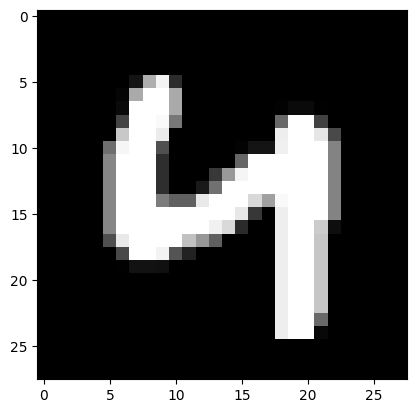

In [140]:
import matplotlib.pyplot as plt
plt.imshow(X[222], cmap="gray")
print(y[153])

In [141]:
test_one = X[222][None, :, :]

test_one_tda = tda_union.transform(test_one)

rf.predict(test_one_tda)

array(['4'], dtype=object)

In [23]:
import tensorflow as tf


In [24]:

model = tf.keras.models.Sequential()
#CNN
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 34)))

model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
              metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        9824      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)             

In [25]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

model.fit(X_train_tda_good, y_train, epochs=10, batch_size=1, validation_data=(X_test_tda_good, y_test))

Epoch 1/10


300/300 [==============================] - 5s 10ms/step - loss: 1.5709 - accuracy: 0.4933 - val_loss: 0.8020 - val_accuracy: 0.7520
Epoch 2/10
300/300 [==============================] - 3s 9ms/step - loss: 0.6952 - accuracy: 0.8033 - val_loss: 0.7877 - val_accuracy: 0.7800
Epoch 3/10
300/300 [==============================] - 3s 9ms/step - loss: 0.4537 - accuracy: 0.8700 - val_loss: 1.1806 - val_accuracy: 0.7460
Epoch 4/10
300/300 [==============================] - 3s 9ms/step - loss: 0.4812 - accuracy: 0.8800 - val_loss: 0.9203 - val_accuracy: 0.7200
Epoch 5/10
300/300 [==============================] - 3s 9ms/step - loss: 0.2611 - accuracy: 0.9367 - val_loss: 0.5619 - val_accuracy: 0.8540
Epoch 6/10
300/300 [==============================] - 3s 8ms/step - loss: 0.1660 - accuracy: 0.9533 - val_loss: 0.7002 - val_accuracy: 0.8500
Epoch 7/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0789 - accuracy: 0.9733 - val_loss: 0.9415 - val_accuracy: 0.8320
Epo

In [32]:
images = tf.keras.datasets.mnist.load_data(path='mnist.npz')
x_test = images[1][0][:50]
y_test = images[1][1][:50]

x_test_tda = tda_union.transform(x_test)

print(x_test.shape, y_test.shape)


(50, 28, 28) (50,)


In [147]:

# save x_test_tda and y_test
np.save('x_test_tda.npy', x_test_tda)
np.save('y_test.npy', y_test)


In [33]:
model.evaluate(x_test_tda, y_test, batch_size=1)

50/50 [==============================] - 0s 3ms/step - loss: 0.7981 - accuracy: 0.8000


[0.7981255054473877, 0.800000011920929]

In [67]:
import matplotlib.pyplot as plt

In [95]:
missed=0
all=0
for i in range(100):
    all+=1
    if np.argmax(model.predict(x_test_tda[i][None, :], verbose=0)) != y_test[i]:
        missed+=1


print(missed, all, missed/all)

12 100 0.12


In [96]:
X_train_flat = X_train.reshape(-1, 28*28)
X_train_flat.shape

X_train_all = np.concatenate((X_train_flat, X_train_tda), axis=1)
X_train_all.shape


X_test_flat = x_test.reshape(-1, 28*28)
X_test_all = np.concatenate((X_test_flat, x_test_tda), axis=1)
X_test_all.shape


(100, 1260)

In [105]:


model = tf.keras.models.Sequential()
# 28x28 = 784 - flatten pixel representation + 476 TDA features
model.add(tf.keras.layers.Input(shape=(28*28+476,)))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 256)               322816    
                                                                 
 dense_24 (Dense)            (None, 256)               65792     
                                                                 
 dense_25 (Dense)            (None, 10)                2570      
                                                                 
Total params: 391178 (1.49 MB)
Trainable params: 391178 (1.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
y_test = y_test.astype(int)

In [107]:
y_train = y_train.astype(int)

model.fit(X_train_all, y_train, epochs=10, batch_size=1)

Epoch 1/40
60/60 [==============================] - 2s 5ms/step - loss: 81.4435 - accuracy: 0.1833
Epoch 2/40
60/60 [==============================] - 0s 6ms/step - loss: 12.6223 - accuracy: 0.7167
Epoch 3/40
60/60 [==============================] - 0s 5ms/step - loss: 3.7602 - accuracy: 0.9167
Epoch 4/40
60/60 [==============================] - 0s 5ms/step - loss: 1.1005 - accuracy: 0.9000
Epoch 5/40
60/60 [==============================] - 0s 6ms/step - loss: 7.1932 - accuracy: 0.8333
Epoch 6/40
60/60 [==============================] - 0s 6ms/step - loss: 5.1155 - accuracy: 0.8167
Epoch 7/40
60/60 [==============================] - 0s 6ms/step - loss: 10.4272 - accuracy: 0.8167
Epoch 8/40
60/60 [==============================] - 0s 7ms/step - loss: 3.6165 - accuracy: 0.9000
Epoch 9/40
60/60 [==============================] - 0s 6ms/step - loss: 7.1667 - accuracy: 0.8667
Epoch 10/40
60/60 [==============================] - 0s 6ms/step - loss: 16.5020 - accuracy: 0.8000
Epoch 11/40
60/

In [41]:
model.evaluate(X_test_tda_good, y_test, batch_size=1)

500/500 [==============================] - 2s 3ms/step - loss: 1.2116 - accuracy: 0.8140


[1.2116310596466064, 0.8140000104904175]

# na przykladzie:


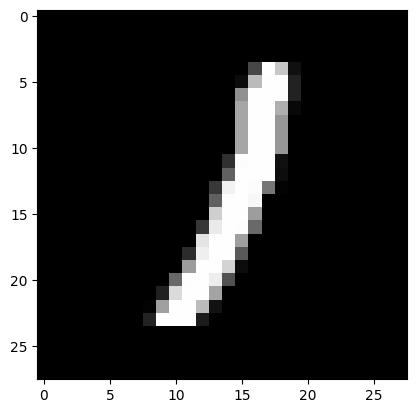

In [56]:
X_test_tda_good[4].shape
plt.imshow(X_test[4], cmap="gray")

In [55]:
np.round(model.predict(X_test_tda_good[4][None, :]),2)

1/1 [==============================] - 0s 48ms/step


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)